In [48]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import numpy as np
import scienceplots
from scipy.sparse.linalg import gmres

In [2]:
#Grid generation
def gridGeneration(x_step,y_step):
    delX = x_step
    delY = y_step
    x_grid = np.arange(-np.pi,np.pi+delX,delX)
    y_grid = np.arange(-np.pi/2,np.pi/2+delY,delY)
    return x_grid,y_grid

In [3]:
def calcPressureExact(x_step,y_step):
    x_grid,y_grid = gridGeneration(x_step,y_step)
    dummy_pressure = np.zeros((len(y_grid),len(x_grid)))
    for i in range(len(y_grid)):
        for j in range(len(x_grid)):
            dummy_pressure[i][j] = -1*(np.cos(2*x_grid[j]) + np.cos(2*y_grid[i]))/4
    return dummy_pressure, x_grid,y_grid

In [4]:
xStepSize = 0.2
yStepSize = 0.1


#Boundary condition

# pressure = np.zeros_like(p_analytical) #analytical solution

# print(np.shape(pressure))

p_analytical,x_grid,y_grid = calcPressureExact(xStepSize,yStepSize)

# for i in range(len(y)):
#     for j in range(len(x)):
#         p_analytical[i][j] = -1*(np.cos(2*x[j]) + np.cos(2*y[i]))/4

pressure = np.copy(p_analytical)
pressure[1:-1,1:-1] = 0 #making all the interior nodes zero.
print(np.shape(pressure))


(33, 33)


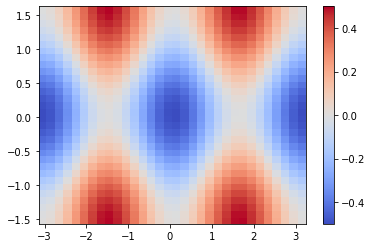

In [5]:
plt.pcolormesh(x_grid,y_grid,p_analytical,cmap='coolwarm')
plt.colorbar()
# plt.grid()

In [6]:
#TDMA from homework 3
def tdma(a,b,c,d):
    n = len(d)
    a, b, c, d = map(np.array, (a, b, c, d)) #Without this line, the a,b,c and d values at the function call get changed 
    for i in range(1,n):
        b[i] = b[i] - c[i-1]*(a[i]/b[i-1])
        d[i] = d[i] - d[i-1]*(a[i]/b[i-1])
    out = np.zeros_like(d)
    out[n-1] = d[n-1]/b[n-1]
    j=n-2
    while(j>=0):
        out[j] = (d[j] - c[j]*out[j+1])/b[j]
        j=j-1
    return out

In [7]:
#Convergence check
def checkConvergence(pk,pk_1):
    yp = np.shape(pk)[0]#no. of rows. iterate along 'y' axis
    xp = np.shape(pk)[1]#no. of columns. iterate along 'x' axis
    error=0.0 
    p_sum = 0.0
    for i in range(1,yp-2): #only the interior nodes to be checked 
        for j in range(1,xp-2):
            error+=np.abs(pk_1[i][j]-pk[i][j])
            p_sum +=np.abs(pk[i][j])
    rel_err = error/(p_sum+1e-10) #Added a very small number to avoid divide by zero error
    return rel_err

In [8]:
#ADI algorithm
def ADI(variable,xStep,yStep,x_grid,y_grid):
    p = np.copy(variable)
    Rows = np.shape(p)[0]
    Columns = np.shape(p)[1]
    beta = xStep/yStep
    delX = xStep
    delY = yStep
    # print(Rows,Columns)
    #x_sweep
    b_x = np.zeros(Columns-2) #size of b and d = no of equations = no. of interior nodes in the implicit direction
    a_x = np.zeros_like(b_x) # 'a' and 'c' are actually of size(b)-1 but to make indexing easy size(a) = size(b) = size(c)
    c_x = np.zeros_like(b_x)
    d_x = np.zeros_like(b_x)
    a_x[:] = 1.0
    b_x[:] = -2*(1+np.power(beta,2))
    c_x[:] = 1.0
    pk_half = np.copy(p)
    for row in range(1,Rows-1):
#         print(b_x)
#         d_x[:] = 0.0 #Needs to be re-initialized without which the first and last values will get retained
        for col in range(1,Columns-1):
            d_x[col-1] = -1*np.power(beta,2)*(p[row+1][col]+pk_half[row-1][col])+np.power(delX,2)*(np.cos(2*x_grid[col])+
                                                                                               np.cos(2*y_grid[row]))
        d_x[0] += -1*p[row][0]
        d_x[-1] += -1*p[row][-1]
        updated_pk_half = tdma(a_x,b_x,c_x,d_x)
#         print("pk_half\n")
#         print(updated_pk_half)
        pk_half[row,1:-1] = updated_pk_half

    #ysweep
    pk_1 = np.copy(pk_half)
    b_y = np.zeros(Rows-2)
    a_y = np.zeros_like(b_y)
    c_y = np.zeros_like(b_y)
    d_y = np.zeros_like(b_y)
    a_y[:] = np.power(beta,2)
    b_y[:] = -2*(1+np.power(beta,2))
    c_y[:] = np.power(beta,2)
    for col in range(1,Columns-1):
#         d_y[:] = 0.0 
        for row in range(1,Rows-1):
            d_y[row-1] = -1*pk_1[row][col-1]-pk_half[row][col+1]+np.power(delX,2)*(np.cos(2*x_grid[col])+np.cos(2*y_grid[row]))
        d_y[0] += -1*np.power(beta,2)*p[0][col]
        d_y[-1] += -1*np.power(beta,2)*p[-1][col]
        updated_pk_1 = tdma(a_y,b_y,c_y,d_y)
#         print("pk_1\n")
#         print(updated_pk_1)
        pk_1[1:-1,col] = updated_pk_1
    return pk_1

In [9]:
def ADI_Iteration(initialField,dx,dy,x_grid,y_grid):
    p_temp = np.copy(initialField)
    converged = False
    iteration = 0
    while(not converged):
        p_iter = ADI(p_temp,dx,dy,x_grid,y_grid)
        error = checkConvergence(p_temp,p_iter)
        iteration+=1
        if(error<1e-5):
            converged=True
#             print(f"Solution converged in {iteration} iterations")
        p_temp = np.copy(p_iter)
    return p_temp,iteration

Gauss Seidel Iteration

In [10]:
def GaussSeidel(var,xStep,yStep,x_grid,y_grid):
    p_gs = np.copy(var)
    delX = xStep
    delY = yStep
    beta = delX/delY
    Rows_gs = np.shape(p_gs)[0]
    Columns_gs = np.shape(p_gs)[1]
    constant_div = 2*(1+np.power(beta,2)) #2*(1+beta^2) 
    for col in range(1,Columns_gs-1):
#         print(col)
        for row in range(1,Rows_gs-1):
#             print(row)
            st_1 = p_gs[row][col+1]+p_gs[row][col-1]+pow(beta,2)*(p_gs[row+1][col]+p_gs[row-1][col])#surrounding nodes 
            st_2 = st_1 - pow(delX,2)*(np.cos(2*x_grid[col])+np.cos(2*y_grid[row]))#the function on the RHS
            p_gs[row][col] = st_2/constant_div #the final value at the node i,j
    return p_gs

In [11]:
def GS_Iteration(initialField,dx,dy,x_grid,y_grid):
    pgs_temp = np.copy(initialField)
    converged_gs = False
    iteration_gs = 0
    while(not converged_gs):
        pgs_iter = GaussSeidel(pgs_temp,dx,dy,x_grid,y_grid)
        error_gs = checkConvergence(pgs_temp,pgs_iter)
        iteration_gs+=1
        if(error_gs<1e-5):
            converged_gs=True
#             print(f"Solution converged in {iteration_gs} iterations")
        pgs_temp = np.copy(pgs_iter)
    return pgs_temp,iteration_gs

GMRES

In [28]:
def ksp_GMRES(var,xStep,yStep,x_grid,y_grid):
    IM = len(x_grid)
    JM = len(y_grid)
    beta = xStep/yStep
    delX = xStep
    unknowns = (IM-2) * (JM-2) #Only the interior nodes need to be solved
    A = np.zeros((unknowns,unknowns)) # Always a square matrix 

    for i in range(1,IM-1):
        for j in range(1,JM-1):
            k = (i-1) + (j-1)*(IM-2) #natural numbering
            A[k,k] = -2*(1+pow(beta,2))
            if(i>1):
                A[k,k-1] = 1 #left element
            if(i<IM-2): 
                A[k,k+1] = 1 #right element
            if(j>1):
                A[k-(IM-2),k] = pow(beta,2) #bottom element
            if(j<JM-2):
                A[k+(IM-2),k] = pow(beta,2) #top element
                
    p_ksp = np.copy(var)
    b = np.zeros(unknowns)
    for row in range(1,JM-1):
        for col in range(1,IM-1):
            k = (col-1) + (row-1)*(IM-2) #natural numbering
            b[k] = pow(delX,2)*(np.cos(2*x_grid[col])+np.cos(2*y_grid[row]))
            if(row==1):#bottom boundary
                b[k] -= pow(beta,2)*p_ksp[0][col]
            if(col==1):#left boundary
                b[k] -= p_ksp[row][0]
            if(row==JM-2):#top boundary
                b[k] -= pow(beta,2)*p_ksp[-1][col]
            if(col==IM-2):#right boundary
                b[k] -= p_ksp[row][-1]
    
    n_iters = [0]
    def iterationCount(arr): 
        n_iters[0]+=1
    Q,info = gmres(A,b,tol=1e-5,callback=iterationCount)
    interior_nodes = Q.reshape(JM-2,IM-2)
    p_ksp[1:-1,1:-1] = interior_nodes
    return p_ksp,n_iters[0]

In [25]:
def kspIter(initialField,dx,dy,x_grid,y_grid):
    pksp_temp = np.copy(initialField)
    pksp,n_iters = ksp_GMRES(pksp_temp,dx,dy,x_grid,y_grid)
    return pksp,n_iters

Accuracy of the numerical scheme

In [12]:
def errorCheck(sol_fd,sol_analytical):
    p_fd = np.copy(sol_fd)
    p_analytical = np.copy(sol_analytical)
    
    jm = np.shape(p_fd)[0]
    im = np.shape(p_fd)[1]
    
    mse = 0 #mean sqaured error
    for j in range(1,jm-1):
        for i in range(1,im-1):
            err = p_fd[j][i] - p_analytical[j][i]
            sq_err = pow(err,2)
            mse+=sq_err
    mse = np.sqrt(mse)
    mse = mse/(jm*im)
    return mse
        

In [161]:
# iterating for different delX or different number of grid points in x direction
xdel_arr = np.arange(0.5,0.05,-0.05)
# beta_xArr = xdel_arr/delY #beta values 
mseList_gs_x = []
iterList_gs_x = []
mseList_adi_x = []
iterList_adi_x = []
mseList_ksp_x = []
iterList_ksp_x = []
yDel = 0.1

ydel_arr = np.arange(0.5,0.05,-0.05)
mseList_gs_y = []
iterList_gs_y = []
mseList_adi_y = []
iterList_adi_y = []
mseList_ksp_y = []
iterList_ksp_y = []
xDel = 0.2

#How error varies with delta x
for delX_iter in xdel_arr:
    temp_p_exact,xArr,yArr = calcPressureExact(delX_iter,yDel)
    temp_p_fd = np.copy(temp_p_exact)
    temp_p_fd[1:-1,1:-1] = 0
    temp_p_adi,adi_iter = ADI_Iteration(temp_p_fd,delX_iter,yDel,xArr,yArr)
    adi_err = errorCheck(temp_p_adi,temp_p_exact)
    mseList_adi_x.append(adi_err)
    iterList_adi_x.append(adi_iter)
    temp_p_gs,gs_iter = GS_Iteration(temp_p_fd,delX_iter,yDel,xArr,yArr)
    gs_err = errorCheck(temp_p_gs,temp_p_exact)
    mseList_gs_x.append(gs_err)
    iterList_gs_x.append(gs_iter)
    temp_p_ksp,ksp_iter = kspIter(temp_p_fd,delX_iter,yDel,xArr,yArr)
    ksp_err = errorCheck(temp_p_ksp,temp_p_exact)
    mseList_ksp_x.append(ksp_err)
    iterList_ksp_x.append(ksp_iter)

#How error varies with delta y
for delY_iter in ydel_arr:
    temp_p_exact,xArr,yArr = calcPressureExact(xDel,delY_iter)
    temp_p_fd = np.copy(temp_p_exact)
    temp_p_fd[1:-1,1:-1] = 0
    temp_p_adi,adi_iter = ADI_Iteration(temp_p_fd,xDel,delY_iter,xArr,yArr)
    adi_err = errorCheck(temp_p_adi,temp_p_exact)
    mseList_adi_y.append(adi_err)
    iterList_adi_y.append(adi_iter)
    temp_p_gs,gs_iter = GS_Iteration(temp_p_fd,xDel,delY_iter,xArr,yArr)
    gs_err = errorCheck(temp_p_gs,temp_p_exact)
    mseList_gs_y.append(gs_err)
    iterList_gs_y.append(gs_iter)
    temp_p_ksp,ksp_iter = kspIter(temp_p_fd,xDel,delY_iter,xArr,yArr)
    ksp_err = errorCheck(temp_p_ksp,temp_p_exact)
    mseList_ksp_y.append(ksp_err)
    iterList_ksp_y.append(ksp_iter)

In [163]:
iterList_adi_x

[32, 37, 45, 54, 68, 91, 123, 175, 262]

In [164]:
iterList_gs_x

[485, 481, 491, 495, 506, 533, 561, 626, 812]

In [165]:
iterList_adi_y

[27, 33, 39, 46, 57, 69, 84, 102, 123]

In [166]:
iterList_gs_y

[191, 182, 189, 194, 212, 231, 268, 346, 561]

In [167]:
np.array(iterList_gs_x)/np.array(iterList_adi_x)

array([15.15625   , 13.        , 10.91111111,  9.16666667,  7.44117647,
        5.85714286,  4.56097561,  3.57714286,  3.09923664])

In [168]:
np.array(iterList_gs_y)/np.array(iterList_adi_y)

array([7.07407407, 5.51515152, 4.84615385, 4.2173913 , 3.71929825,
       3.34782609, 3.19047619, 3.39215686, 4.56097561])

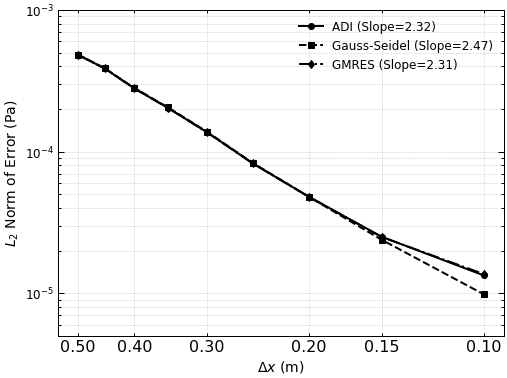

In [174]:
# Compute convergence slopes
slope_adi, _ = np.polyfit(np.log(xdel_arr), np.log(mseList_adi_x), 1)
slope_gs, _ = np.polyfit(np.log(xdel_arr), np.log(mseList_gs_x), 1)
slope_ksp, _ = np.polyfit(np.log(xdel_arr), np.log(mseList_ksp_x), 1)

# Create figure
# plt.figure(figsize=[8, 5])
plt.xscale("log")
plt.yscale("log")
plt.gca().invert_xaxis()  # Reverse x-axis for decreasing step size

# Plot data
plt.plot(xdel_arr, mseList_adi_x, '-ok', label=f"ADI (Slope={slope_adi:.2f})", markersize=6, linewidth=2)
plt.plot(xdel_arr, mseList_gs_x, '--sk', label=f"Gauss-Seidel (Slope={slope_gs:.2f})", markersize=6, linewidth=2)
plt.plot(xdel_arr, mseList_ksp_x, '-.dk', label=f"GMRES (Slope={slope_ksp:.2f})", markersize=6, linewidth=2)

# Formatting tick marks
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=6))
ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=6))


y_ticks = ax.yaxis.get_majorticklocs()  # Get current major ticks
y_ticks = np.unique(y_ticks)  # Remove duplicates
ax.set_yticks(y_ticks)  # Apply new tick values

ax.xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs='auto', numticks=10))
ax.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs='auto', numticks=10))

# Grid formatting
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

plt.ylim(5e-6, 1e-3)

# Labels and title
plt.xlabel(r"$\Delta x$ (m)", fontsize=14)
plt.ylabel(r"$L_2$ Norm of Error (Pa)", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

locs = np.append(np.arange(0.5,0.2,-0.10),np.arange(0.2,0.05,-0.05))

ax.xaxis.set_minor_locator(ticker.FixedLocator(locs))
ax.xaxis.set_major_locator(ticker.NullLocator())

ax.xaxis.set_minor_formatter(ticker.ScalarFormatter())

# Legend formatting
plt.legend(loc="best", fontsize=12, frameon=False)

plt.savefig("delXError_new.png",dpi=300)
# Show the plot
plt.show()


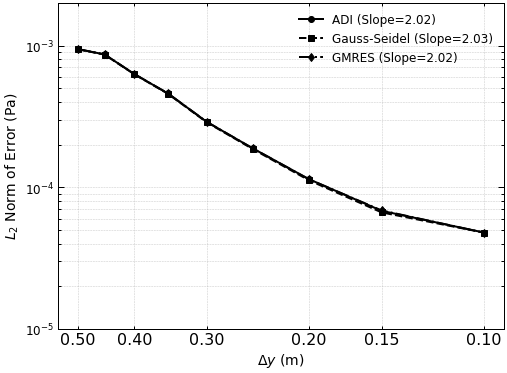

In [176]:
# Compute convergence slopes
slope_adi_y, _ = np.polyfit(np.log(ydel_arr), np.log(mseList_adi_y), 1)
slope_gs_y, _ = np.polyfit(np.log(ydel_arr), np.log(mseList_gs_y), 1)
slope_ksp_y, _ = np.polyfit(np.log(ydel_arr), np.log(mseList_ksp_y), 1)


plt.xscale("log")
plt.yscale("log")
plt.gca().invert_xaxis()  # Reverse x-axis for decreasing step size


plt.plot(ydel_arr, mseList_adi_y, '-ok', label=f"ADI (Slope={slope_adi_y:.2f})", markersize=6, linewidth=2)
plt.plot(ydel_arr, mseList_gs_y, '--sk', label=f"Gauss-Seidel (Slope={slope_gs_y:.2f})", markersize=6, linewidth=2)
plt.plot(ydel_arr, mseList_ksp_y, '-.dk', label=f"GMRES (Slope={slope_ksp_y:.2f})", markersize=6, linewidth=2)


ax = plt.gca()
ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=6))
ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=6))


y_ticks = ax.yaxis.get_majorticklocs()  
y_ticks = np.unique(y_ticks)  
ax.set_yticks(y_ticks)  

ax.xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs='auto', numticks=10))
ax.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs='auto', numticks=10))


plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

plt.ylim(1e-5, 2e-3)

# Labels and title
plt.xlabel(r"$\Delta y$ (m)", fontsize=14)
plt.ylabel(r"$L_2$ Norm of Error (Pa)", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

locs = np.append(np.arange(0.5,0.2,-0.10),np.arange(0.2,0.05,-0.05))

ax.xaxis.set_minor_locator(ticker.FixedLocator(locs))
ax.xaxis.set_major_locator(ticker.NullLocator())

ax.xaxis.set_minor_formatter(ticker.ScalarFormatter())


plt.legend(loc="best", fontsize=12, frameon=False)

plt.savefig("delYError_new.png",dpi=300)
# Show the plot
plt.show()


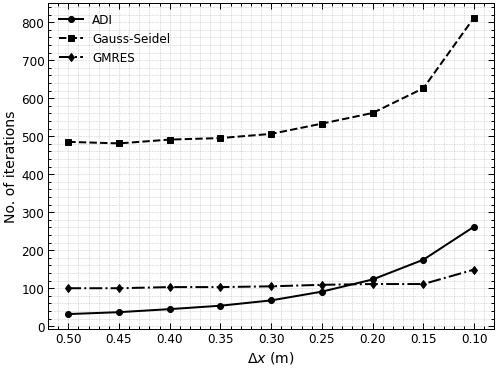

In [177]:
plt.plot(xdel_arr, iterList_adi_x, '-ok', label=f"ADI", markersize=6, linewidth=2)
plt.plot(xdel_arr, iterList_gs_x, '--sk', label=f"Gauss-Seidel", markersize=6, linewidth=2)
plt.plot(xdel_arr, iterList_ksp_x, '-.dk', label=f"GMRES", markersize=6, linewidth=2)

# Formatting tick marks
ax = plt.gca()
plt.gca().invert_xaxis()

# Grid formatting
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

# plt.ylim(1e-5, 2e-3)

# Labels and title
plt.xlabel(r"$\Delta x$ (m)", fontsize=14)
plt.ylabel(r"No. of iterations", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Legend formatting
plt.legend(loc="best", fontsize=12, frameon=False)

plt.savefig("iterationDelX_new.png",dpi=300)
# Show the plot
plt.show()


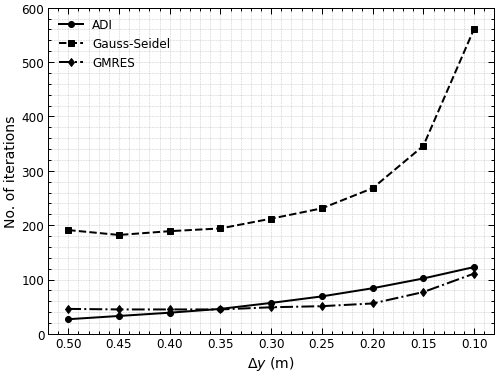

In [178]:
plt.plot(ydel_arr, iterList_adi_y, '-ok', label=f"ADI", markersize=6, linewidth=2)
plt.plot(ydel_arr, iterList_gs_y, '--sk', label=f"Gauss-Seidel", markersize=6, linewidth=2)
plt.plot(ydel_arr, iterList_ksp_y, '-.dk', label=f"GMRES", markersize=6, linewidth=2)

# Formatting tick marks
ax = plt.gca()
plt.gca().invert_xaxis()

# Grid formatting
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

plt.ylim(0, 600)

# Labels and title
plt.xlabel(r"$\Delta y$ (m)", fontsize=14)
plt.ylabel(r"No. of iterations", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Legend formatting
plt.legend(loc="best", fontsize=12, frameon=False)

plt.savefig("iterationDelY_new.png",dpi=300)
# Show the plot
plt.show()